# The Lorenz Attractor

### Predicting Trajectory/Shape

Attempt to use the Keras API to create a RNN to predict the shape of the model based of a known trajectory. Train the model to be more generalized with different initial starting conditions. We will not use a stateful model, as the batches are chosen to be large enough that states are independent from any previous states not in batch. See the auto correlation in the Exploring The Lorenz Attractor notebook.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout
from tensorflow.keras import metrics
from tensorflow.keras import losses, backend

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.gridspec import GridSpec

plt.style.use("astro")

import numpy as np
from tqdm import tqdm
from tqdm.keras import TqdmCallback

from Lorenz import LorenzAttractor

C:\Users\Patrick\Anaconda3\envs\Lorenz\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Creating the data

In [2]:
# Set up Lorenz attractor shape and initial parameters
INITIALSTATE = (1.0, 1.0, 1.0)
SIGMA = 10.0
BETA = 8/3.0
RHO = 28.0

# Set integration time sequence for solveing
tStart = 0.0
tEnd = 30.0
dt = 0.001

t = np.arange(tStart, tEnd, dt)
n = len(t)

In [3]:
""" create the dataset"""
LA = LorenzAttractor(t, INITIALSTATE, SIGMA, BETA, RHO)
X, Y, Z = LA.get_states()

### Data Preprocessing

In [4]:
TrainingAttractor = np.array([X, Y, Z]).T
print(TrainingAttractor.shape)

(30000, 3)


Need train and validation data to be in shape `[samples, timesteps, features]`. One sequence is one sample, a batch is comprised of one or more samples, one time step is one point of observation in the sample,  and one feature is one observation at a time step. lets take samples of 100 time steps or 3 features (X, Y, Z sates).

``` [samples, timesteps, features] = [..., 100, 3] ```

In [5]:
lookback = 100 # time steps in sample
trainSize = int(len(TrainingAttractor)*0.75) # 75% of data set

Make a number of samples where there is 100 time steps and the target state is the first timestep of the next state in the sequence.

In [6]:
# creating rolling timesteps with jump=1
rollingSamples = []
for i in range(len(TrainingAttractor)-lookback):
    rollingSamples.append(np.array(TrainingAttractor[i:lookback+i]))

rollingSamples = np.array(rollingSamples) # make numpy array
print(rollingSamples.shape)

(29900, 100, 3)


Uneven lookback and target for the number of computed timesteps in the TrainingAttractor, thus the 29900 batches instead of the full 30000.

In [7]:
# check rolling timestep batches by 1
print(rollingSamples[0][1])
print(rollingSamples[1][0])

[1.00012952 1.02598902 0.99834858]
[1.00012952 1.02598902 0.99834858]


In [8]:
# define training and validation sets

trainInput = rollingSamples[:trainSize]
trainOutput = np.array([state for state in trainInput[lookback:,0,:]])


valInput = rollingSamples[trainSize:]
valOutput = np.array([state for state in valInput[lookback:,0,:]])

trainInput, valInput = trainInput[:-lookback], valInput[:-lookback] # remove last sample (won't have known outputs)

# input_shape = (samples, timesteps, dim)
print("Training set input: ", trainInput.shape)
print("Training set output: ",trainOutput.shape)
print("Validation set input: ",valInput.shape)
print("Validation set output: ",valOutput.shape)

Training set input:  (22400, 100, 3)
Training set output:  (22400, 3)
Validation set input:  (7300, 100, 3)
Validation set output:  (7300, 3)


(22400,)
(22400, 3)


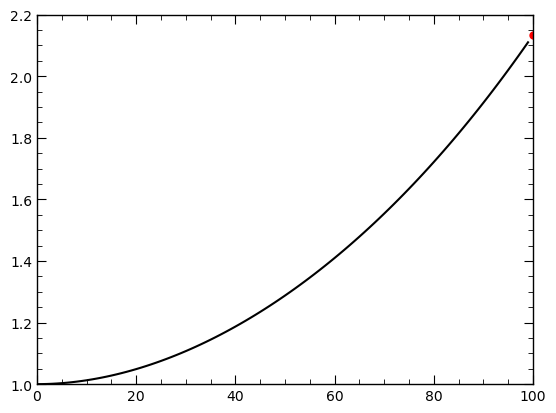

In [9]:
x = np.arange(100, len(trainOutput)*100+100, 100)
print(x.shape)
print(trainOutput.shape)

plt.plot(trainInput[0,:,0], "k-") # sample
plt.scatter([100], trainOutput[0,0], s=25, c="r") # target

Looking at how the target data is formed the model may have trouble getting out to extreme points/peaks as the targets are not always on the peaks.

This would take some looking into to solve this if it comes up as a problem in the RNN network.

### Create the RNN Model

To evaluate the model, we will use a custom metric and backend methods to evaluate the loss and accuracy of both the training and validation.  Using the metric 'accuracy', we get the built in metric for the validation quality using the root mean squared error between the predicted value and the validation target data.

$$ RMSE = \sqrt{\frac{\sum_i(X_i - \bar{X})^2}{n}} $$

This is related to the mean squared error but the square root mean keeps the dimesionality of the vertical axis when finding the mean distance from the fit. (Say MSE gives $m^2$ for $m$ input, root mean squared gives $m$)

In [10]:
def rmse(y_true, y_pred):
    """ Custom metric to pass to the compiler for the model """
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

In [11]:
""" Sequential RNN model """
# create the RNN layer:
Model_RNN = Sequential()

Model_RNN.add(LSTM(units=8, 
                   return_sequences=True, # true if using second LSTM layer
                   input_shape=(lookback, 3),
                   dropout=0.2)) # Recurrent Layer

Model_RNN.add(LSTM(units=64, dropout=0.2))
#Model_RNN.add(Dense(32, input_dim=3, activation="relu")) # Fully connected layer\
Model_RNN.add(Dense(3, activation="linear")) # Fully connected output layer

opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-7)
Model_RNN.compile(loss=rmse, optimizer=opt, metrics=["accuracy"])
Model_RNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 8)            384       
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                18688     
_________________________________________________________________
dense (Dense)                (None, 3)                 195       
Total params: 19,267
Trainable params: 19,267
Non-trainable params: 0
_________________________________________________________________


### Train RNN Model

In [12]:
""" Train the model """
Model_fitted = Model_RNN.fit(trainInput, trainOutput,
                             epochs=16,
                             validation_data=(valInput,
                                              valOutput
                                             ),
                             # Nicer output for so many Epochs
                             verbose=1,
                             #callbacks=[TqdmCallback(verbose=0)]
                            )
print(Model_fitted.history.keys())

Train on 22400 samples, validate on 7300 samples
Epoch 1/16
22400/22400 [==============================] - 68s 3ms/sample - loss: 5.7131 - accuracy: 0.9857 - val_loss: 5.5767 - val_accuracy: 0.9929
Epoch 2/16
22400/22400 [==============================] - 64s 3ms/sample - loss: 2.8464 - accuracy: 0.9873 - val_loss: 3.4794 - val_accuracy: 0.9901
Epoch 3/16
22400/22400 [==============================] - 63s 3ms/sample - loss: 1.3477 - accuracy: 0.9942 - val_loss: 2.5244 - val_accuracy: 0.9886
Epoch 4/16
22400/22400 [==============================] - 62s 3ms/sample - loss: 0.8906 - accuracy: 0.9961 - val_loss: 2.0524 - val_accuracy: 0.9853
Epoch 5/16
22400/22400 [==============================] - 62s 3ms/sample - loss: 0.6885 - accuracy: 0.9967 - val_loss: 2.0854 - val_accuracy: 0.9834
Epoch 6/16
22400/22400 [==============================] - 66s 3ms/sample - loss: 0.5800 - accuracy: 0.9984 - val_loss: 2.5538 - val_accuracy: 0.9814
Epoch 7/16
22400/22400 [==============================] -

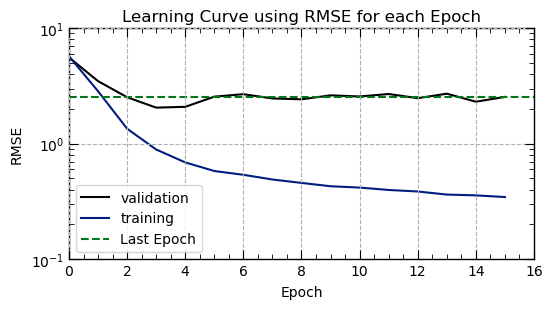

In [13]:
training = Model_fitted.history['loss']
validation = Model_fitted.history['val_loss']

plt.figure(figsize=(6,3))
plt.plot(validation, label="validation")
plt.plot(training, label="training")
plt.plot([0,len(training)],[validation[-1], validation[-1]], label="Last Epoch", ls="--")
plt.yscale("log")
plt.title('Learning Curve using RMSE for each Epoch')
plt.xlabel('Epoch'); plt.ylabel('RMSE')
plt.legend(loc=0); plt.grid(ls="--")

With different neural network architectures with multiple LSTM layers, or adding a dense layer just before the output layer, the validation loss was having a hard time going below RMSE=2.0. Updating the hyperparameters (i.e. the number of cells in the LSTM), giving the model more complexity did not help reducing the validation loss.

The LSTM layers may not have the capibilities for non-linear systems as the connection between different cells in note the same as dense layers. Another possibility is the training dataset does not have the variation it needs for generalization.

Just from this, the perceptron network worked much better and also trained quite a bit faster.